In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



In [58]:
train = pd.read_csv('train_users_2.csv')
test = pd.read_csv('test_users.csv')
country = pd.read_csv('countries.csv')
age_gender = pd.read_csv('age_gender_bkts.csv')

In [59]:
country.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [60]:
age_gender.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [61]:
train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


It does not make ssense that people aged 1 or 2014.To keep it reasonable, just set users who aged outside the range 18-100 as NA

In [62]:
train.loc[train.age > 100, 'age'] = np.nan
train.loc[train.age < 18, 'age'] = np.nan

test.loc[test.age > 100, 'age'] = np.nan
test.loc[test.age < 18, 'age'] = np.nan

In [63]:
train.gender.unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

There is no Na in gender data, in order to make it easier to analyze, we are going to replace unknown to nan

In [64]:
train.gender.replace('-unknown-', np.nan, inplace=True)
test.gender.replace('-unknown-', np.nan, inplace=True)

In [65]:
train.first_browser.replace('-unknown-', np.nan, inplace=True)
test.first_browser.replace('-unknown-', np.nan, inplace=True)

Text(0.5, 1.0, 'test')

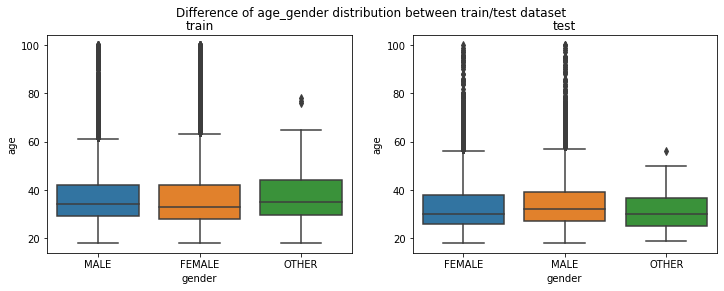

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Difference of age_gender distribution between train/test dataset')
sns.boxplot(x='gender', y='age', data=train, ax=ax[0])
ax[0].set_title('train')
sns.boxplot(x='gender', y='age', data=test, ax=ax[1])
ax[1].set_title('test')

we can see age-gender ratio does not make any big difference, and most of the people are aged around 35.




and lets find some insgiht from the date information

In [67]:

#convert columns into datetime format first
train['date_account_created'] = pd.to_datetime(train['date_account_created'], format='%Y-%m-%d')
test['date_account_created'] = pd.to_datetime(test['date_account_created'], format='%Y-%m-%d')
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], format='%Y-%m-%d')
test['date_first_booking'] = pd.to_datetime(test['date_first_booking'], format='%Y-%m-%d')


#year, month, day from the active date
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'].astype(str).str[:8])
test['timestamp_first_active'] = pd.to_datetime(test['timestamp_first_active'].astype(str).str[:8])

In [68]:
#the day between first active and account_created
sign_diff_train = train['timestamp_first_active']-train['date_account_created']
sign_diff_test = test['timestamp_first_active']-test['date_account_created']

sign_diff_test.describe(),sign_diff_train.describe()

(count              62096
 mean     0 days 00:00:00
 std      0 days 00:00:00
 min      0 days 00:00:00
 25%      0 days 00:00:00
 50%      0 days 00:00:00
 75%      0 days 00:00:00
 max      0 days 00:00:00
 dtype: object,
 count                         213451
 mean     -1 days +18:26:10.837335033
 std       11 days 22:45:41.307539071
 min             -1456 days +00:00:00
 25%                  0 days 00:00:00
 50%                  0 days 00:00:00
 75%                  0 days 00:00:00
 max                  0 days 00:00:00
 dtype: object)

we can see most of the users sign up after first activity. The users may have to sign in o unlock some hidden contenet in the website.


In [69]:
booking_diff_train = train['date_first_booking']-train['date_account_created']
booking_diff_test = test['date_first_booking']-test['date_account_created']
booking_diff_test.describe(),booking_diff_train.describe()


(count      0
 mean     NaT
 std      NaT
 min      NaT
 25%      NaT
 50%      NaT
 75%      NaT
 max      NaT
 dtype: object,
 count                         88908
 mean     44 days 08:41:59.854231340
 std      87 days 11:59:22.090141649
 min             -349 days +00:00:00
 25%                 1 days 00:00:00
 50%                 3 days 00:00:00
 75%                29 days 00:00:00
 max               365 days 00:00:00
 dtype: object)

people usually make their first booking 44 days after first sign up

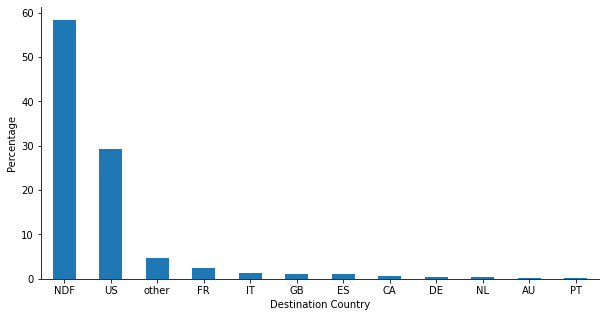

In [70]:
plt.figure(figsize=(10,5))
country_share = train['country_destination'].value_counts() / train.shape[0] * 100
country_share.plot(kind='bar', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

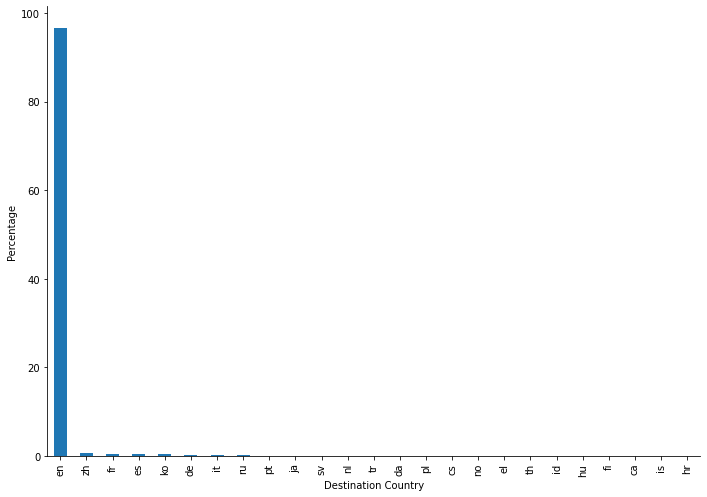

In [71]:

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
destination_percentage = train.language.value_counts() / train.shape[0] * 100
destination_percentage.plot(kind='bar')
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

As can be seen above,around 58% users have not made any booking yet, and 95% of users are eenglish speaker, and in between, most of them hadn't made an appointmnet yet. And the popular destination of english speaker is US. It may be due to Airbnb is a US brand company and  getting popularity first in US. 


In [72]:
lc = train.groupby(['language','country_destination']).id.count().reset_index()
lc2 = lc[lc['country_destination']!='NDF']

fig = px.bar(lc2, x="language", y="id", color="country_destination")
fig.show()

In [73]:
lc_not_us = lc2[lc2['language']!='en']
fig = px.bar(lc_not_us, x="language", y="id", color="country_destination", title="non-english language speaker destination")
fig.show()

Most english speaker and non-english speaker will choos US as the destination. The theory is that Airbnb was founded in US and getting popular in US, there are more Airbnb host than other countires,in turnm more users will choose Airbnb rather than hotel.

<AxesSubplot:xlabel='count', ylabel='first_device_type'>

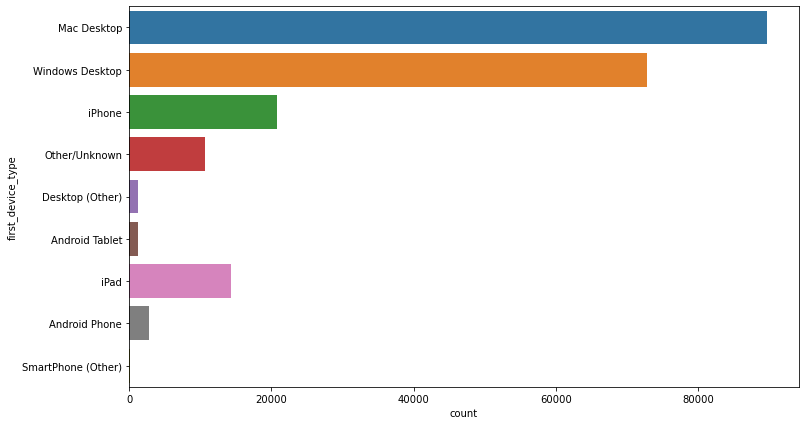

In [74]:
plt.figure(figsize=(12,7))
sns.countplot(y='first_device_type', data=train)


as above, we can see Mac Desktop is the mos popular device among the users. And other Apple product are also popular with the airbnb users. we can guess that the Aribnb user expxperience design in Aplle is better than other products

<AxesSubplot:xlabel='count', ylabel='signup_app'>

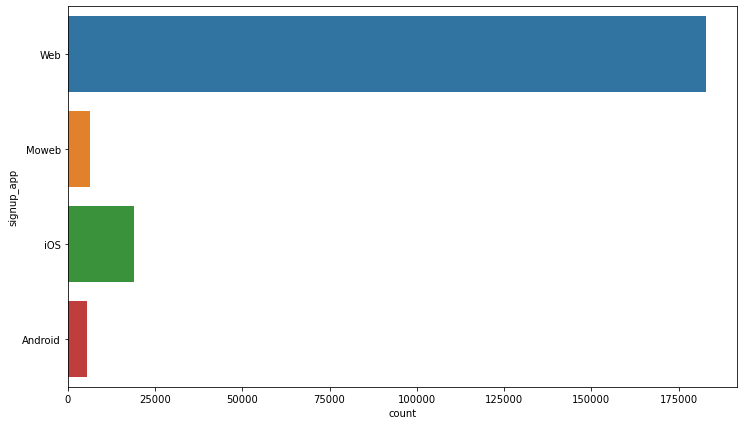

In [75]:
plt.figure(figsize=(12,7))
sns.countplot(y='signup_app', data=train)

Users using the Web App are most likely to book an Airbnb whereas Android Users are least likely to do so.
People on Desktops are more likely to book airbnb, People with an Android Phone bought fewer Airbnbs..
It shows the users with apple product are most likely to book wherea Android Users are least likely to do.

Build Model 

In [76]:
import pandas as pd
#m merge train dataframe and test dataframe
data = pd.concat((train, test), axis=0, ignore_index=True)
data.drop(['id', 'date_first_booking'], axis=1, inplace=True)

#mark the size of train set for afterward spliting
train_size = train.shape[0]

# Split sign-up date into year, month, day
data['sign_up_year'] = data.date_account_created.dt.year
data['sign_up_month'] = data.date_account_created.dt.month
data['sign_up_day'] = data.date_account_created.dt.day

# Split active timestamp into year, month, day
data['active_year'] = data.timestamp_first_active.dt.year
data['active_month'] = data.timestamp_first_active.dt.month
data['active_day'] = data.timestamp_first_active.dt.day

#drop original datetime column
data.drop('date_account_created', axis=1, inplace=True)
data.drop('timestamp_first_active', axis=1, inplace=True)

#fill the missing values by 0
data = data.fillna(0)
#drop the Y
data.drop('country_destination',axis=1,inplace=True)

one hot encoding method.

The categorical variables cannot be used in the machine learning models. We need to encode them into numeric values.

In [77]:
category = list(data.dtypes[data.dtypes == 'object'].reset_index()['index'])
def convertion(data):
    for col in category:
        dummy = pd.get_dummies(data[col], prefix=col)
        data.drop([col], axis=1, inplace=True)
        data = pd.concat((data, dummy), axis=1)
    return data

data = convertion(data)

In [78]:
X = data[:train_size]
le = LabelEncoder()
y = le.fit_transform(train["country_destination"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lg = LogisticRegression()
lg.fit(X_train, y_train)
pred_lg=lg.predict(X_test)
print(accuracy_score(y_test, pred_lg))

0.5658535823599226


E:\docs\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=20, n_estimators=100)
rf.fit(X_train , y_train)
pred = rf.predict(X_test)
print(accuracy_score(y_test, pred))

0.6294115809856955


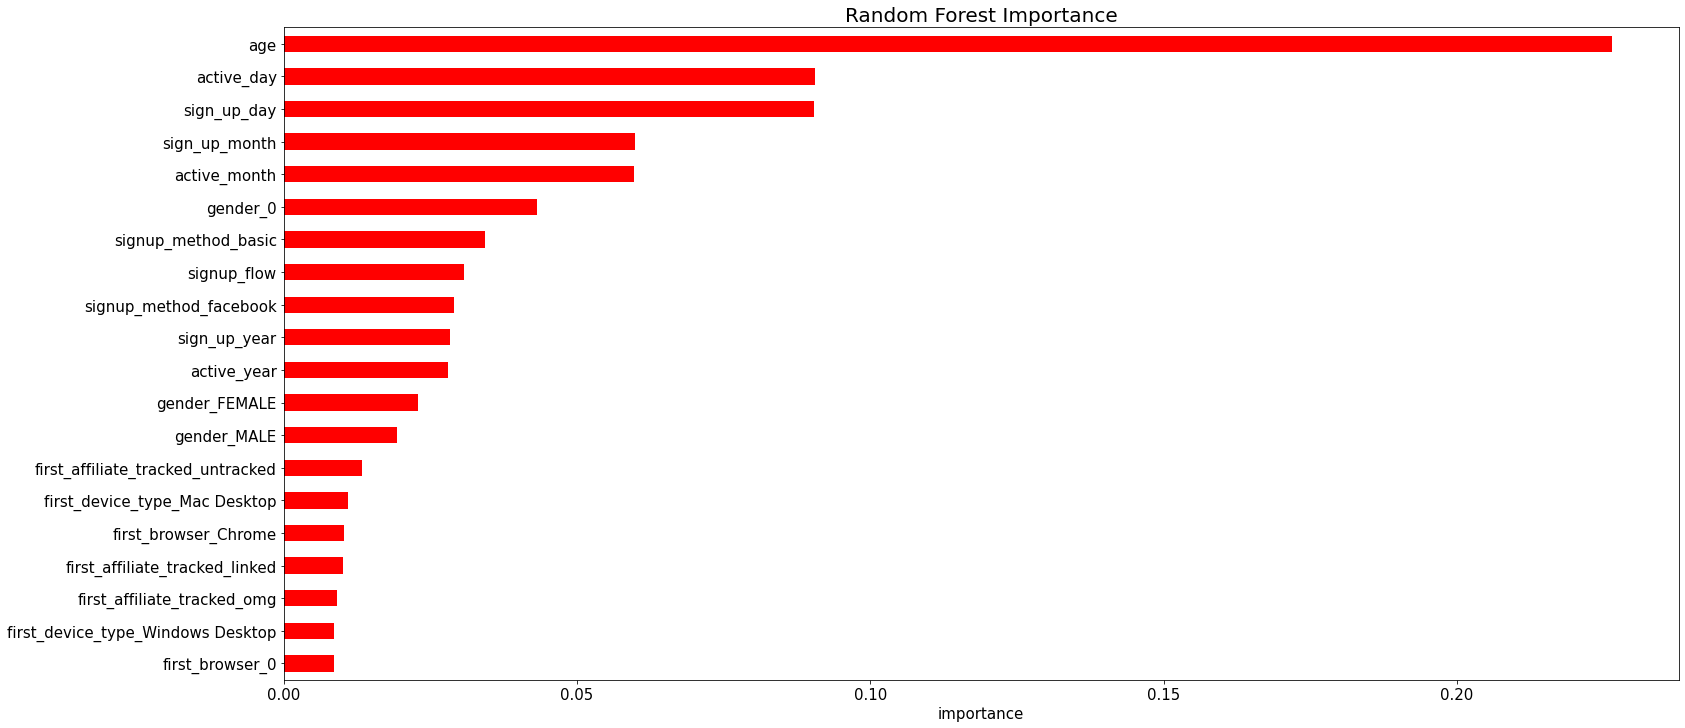

In [84]:
#estimate feature importance
fi=pd.Series(rf.feature_importances_, index=X_test.columns)
fn=fi.sort_values(ascending=True)
fn[-20:].plot(kind='barh', color='r', figsize=(25, 12))
plt.xlabel('importance', size=15)
plt.title('Random Forest Importance', size=20)
plt.tick_params(labelsize=15)

In [55]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train , y_train)
pred = dtc.predict(X_test)
print(accuracy_score(y_test, pred))

0.629645824223874


Conclusion: 

We can see the model based on logistic regression, random forest,decision trees to predict the destination country of Airbnb users with more than 50% accuracy. The varibales identidfied as important features in the model included gender, age, sign_up method, and the features we calculated using the date data. Overall, the random forest with 63% accuracy is the brest model for predicting wether a user will make an AirBnb book, and the destination of country.




Recommendations:

Most of the Airbnb's users are on Aplle devices, and the android users are the least likely to make a booking. Focus on developing the user experience design of iOS Apps will make ssense, Also it is better to investigate in to the smaller conversion rate of andriod users, and try to find the correlations with andriod apps and improve the users experience,

Most of the Aibnb's users make the book within the country. Hence, it makes ssenes to give the users more recommendations that are related to this country. And USA users should get more host recommendations within USA since majority of Airbnb users are likely to make a book in US.

People who do not register their personal information are least likely to book. It seems like they are only in the exploration stage, so we can send the coupon to the new register to maxmize the value at there people.





